In [1]:
# conda create -n limo python=3.9
# conda activate limo
# pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# pip install selfies scipy tqdm
# conda install lightning -c conda-forge
# conda install -y rdkit==2022.03.2 openbabel ipykernel -c conda-forge
# python preprocess_data.py --smiles combined.smi
# watch -n 0.5 nvidia-smi

from utils import *
from models import *
import torch
import pytorch_lightning as pl
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

In [2]:
# dataset
print(dm.dataset.alphabet, dm.dataset.max_len)

# load vae model
vae = VAE(max_len=dm.dataset.max_len, 
          vocab_len=len(dm.dataset.symbol_to_idx), 
          latent_dim=1024, embedding_dim=64).to(device)
vae.load_state_dict(torch.load('vae.pt'))
vae.eval()

# load property predictors
props = ['binding_affinity', 'penalized_logp', 'qed', 'sa', 'toxicity']
models = {}; models_tran = {}
for prop_name in props:
    models[prop_name] = PropertyPredictor(dm.dataset.max_len * len(dm.dataset.symbol_to_idx)).to(device)
    models[prop_name].load_state_dict(torch.load(f'property_models/vae/{prop_name}.pt'))
    models_tran[prop_name] = PropertyPredictor(dm.dataset.max_len * len(dm.dataset.symbol_to_idx)).to(device)
    models_tran[prop_name].load_state_dict(torch.load(f'property_models/tran/{prop_name}.pt'))


['[nop]', '[#Branch1]', '[#Branch2]', '[#C]', '[#N+1]', '[#N]', '[-/Ring1]', '[-/Ring2]', '[-\\Ring1]', '[/Br]', '[/C@@H1]', '[/C@@]', '[/C@H1]', '[/C@]', '[/C]', '[/Cl]', '[/F]', '[/N+1]', '[/N-1]', '[/NH1+1]', '[/NH1-1]', '[/NH1]', '[/NH2+1]', '[/N]', '[/O+1]', '[/O-1]', '[/O]', '[/S-1]', '[/S@]', '[/S]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N-1]', '[=NH1+1]', '[=NH2+1]', '[=N]', '[=O+1]', '[=OH1+1]', '[=O]', '[=P@@]', '[=P@]', '[=PH2]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S+1]', '[=S@@]', '[=S@]', '[=SH1+1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@@]', '[C@H1]', '[C@]', '[CH1-1]', '[CH2-1]', '[C]', '[Cl]', '[F]', '[I]', '[N+1]', '[N-1]', '[NH1+1]', '[NH1-1]', '[NH1]', '[NH2+1]', '[NH3+1]', '[N]', '[O-1]', '[O]', '[P+1]', '[P@@H1]', '[P@@]', '[P@]', '[PH1+1]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S-1]', '[S@@+1]', '[S@@]', '[S@]', '[S]', '[\\Br]', '[\\C@@H1]', '[\\C@H1]', '[\\C]', '[\\Cl]', '[\\F]', '[\\I]', '[\\N+1]', '[\\N-1]', '[\\NH1+1]', 

In [3]:
# start with 100 random molecules
num_mols = 100
z = torch.randn((num_mols, 1024), device=device, requires_grad=True).to(device)

In [4]:
%matplotlib inline

def optimize(property, z, num_steps, lr = 0.6, opt = 'Adam', sched = '', model = vae, plot = None):
    z.requires_grad = True; z.to(device)
    zs = []; losses = []; plotlosses = []
    propmod = models[property] if model == vae else models_tran[property]
    if opt == 'Adam': # converge quickly
        optimizer = optim.Adam([z], lr=lr)
    elif opt == 'SGD': # vanilla SGD
        optimizer = optim.SGD([z], lr=lr)
    elif opt == 'Adagrad': # for sparse gradients
        optimizer = optim.Adagrad([z], lr=lr)
    elif opt == 'AdamW': # weighted Adam
        optimizer = optim.AdamW([z], lr=lr)
    if sched == '':
        scheduler = None
    elif sched == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    elif sched == 'CyclicLR': # restarts
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr = 2*lr, step_size_up=10)
    elif sched == 'CosineAnnealingLR': # warm restarts
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    for _ in tqdm(range(num_steps), desc='generating molecules'):
        optimizer.zero_grad()
        probs = torch.exp(model.decode(z))
        loss = torch.sum(propmod(probs)) * (-1 if property == 'qed' else 1)
        if not plot is None:
            plotloss = torch.sum(propmod(probs)) * (-1 if plot == 'qed' else 1)
        zs.append(z.clone().data); losses.append(loss.item())
        if not plot is None: 
            plotlosses.append(plotloss.item())
        loss.backward(); optimizer.step()
        if sched != '':
            scheduler.step()
    if plot is None:
        return zs, losses
    return zs, losses, plotlosses

def visualize(property, zs, losses, index = 0, model = vae, plotlosses = None):
    # show losses
    fig = plt.figure()
    ax = plt.axes()
    ax.set_title(property + ' with iterations')
    ax.plot(losses)
    if not plotlosses is None:
        ax2 = ax.twinx()
        ax2.plot(plotlosses, color='r')
    plt.show()
    # show first, middle and last molecule
    for z in [zs[0], zs[len(zs)//2], zs[-1]]:
        out = torch.exp(model.decode(z)).reshape((num_mols, -1, model.vocab_len))
        for hot in out:
            smiles = one_hot_to_smiles(hot)
        molecule = Chem.MolFromSmiles(smiles)
        fig = Draw.MolToMPL(molecule)
        plt.axis('off'); plt.tight_layout()
        plt.show()

generating molecules:   0%|          | 0/200 [00:00<?, ?it/s]

generating molecules: 100%|██████████| 200/200 [00:07<00:00, 26.95it/s]


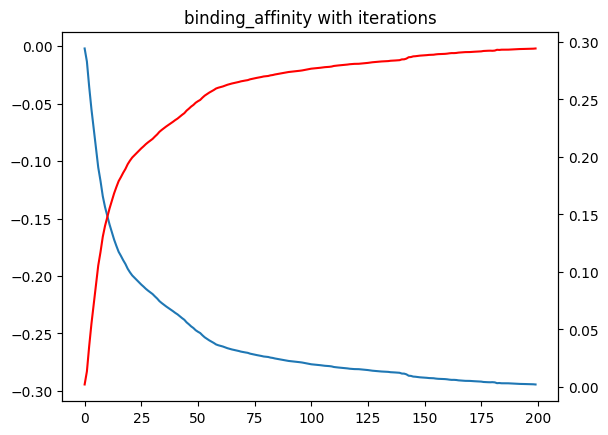

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_45209/3025318159.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


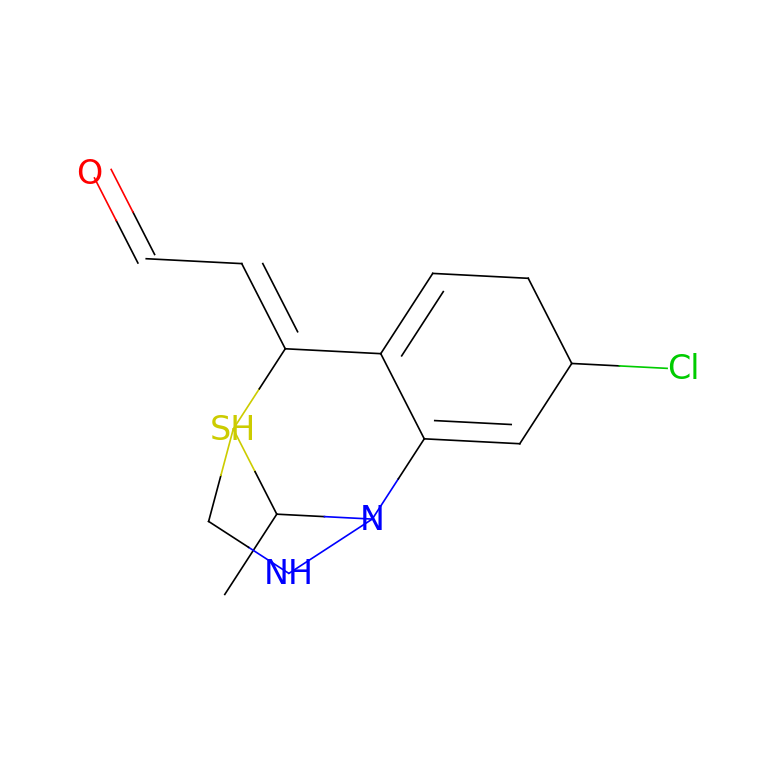

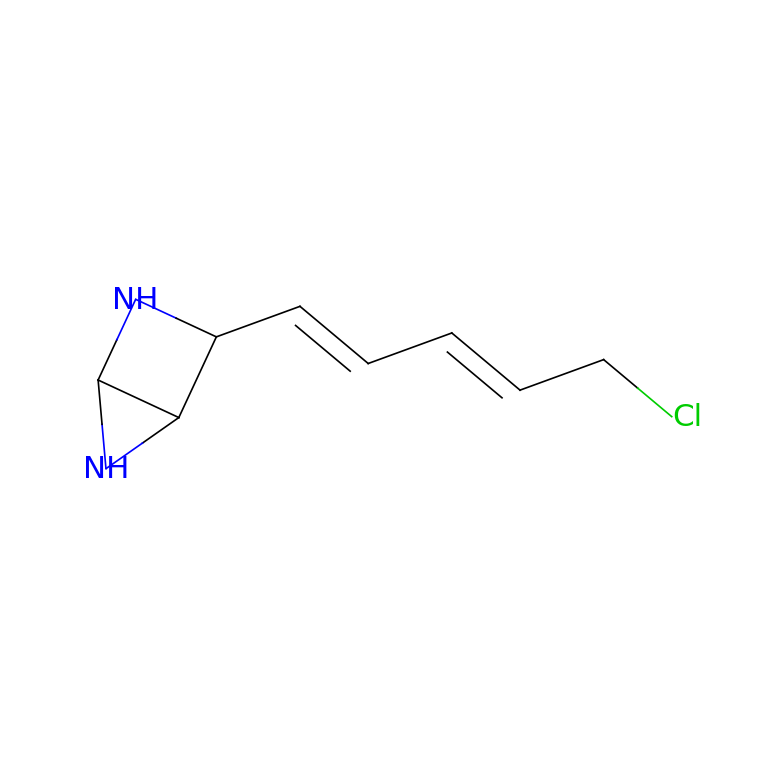

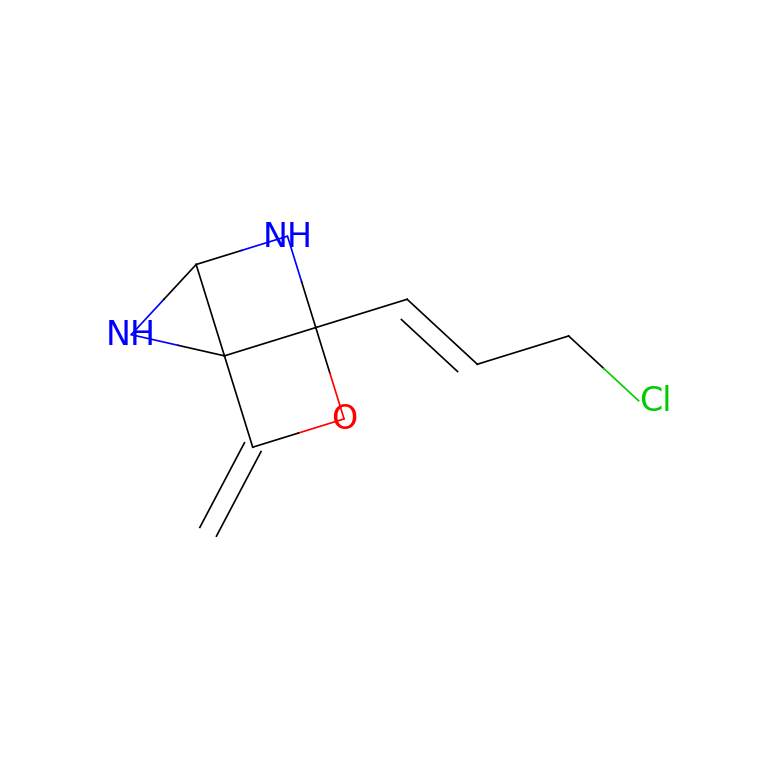

In [5]:
property = 'binding_affinity'
zs, losses, plotlosses = optimize(property, z.detach().clone(), 200, plot='qed')
visualize(property, zs, losses, plotlosses = plotlosses)

generating molecules: 100%|██████████| 200/200 [00:06<00:00, 29.15it/s]


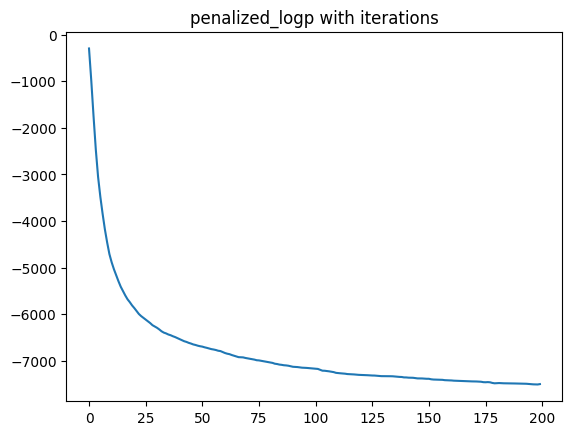

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_39058/2469527915.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


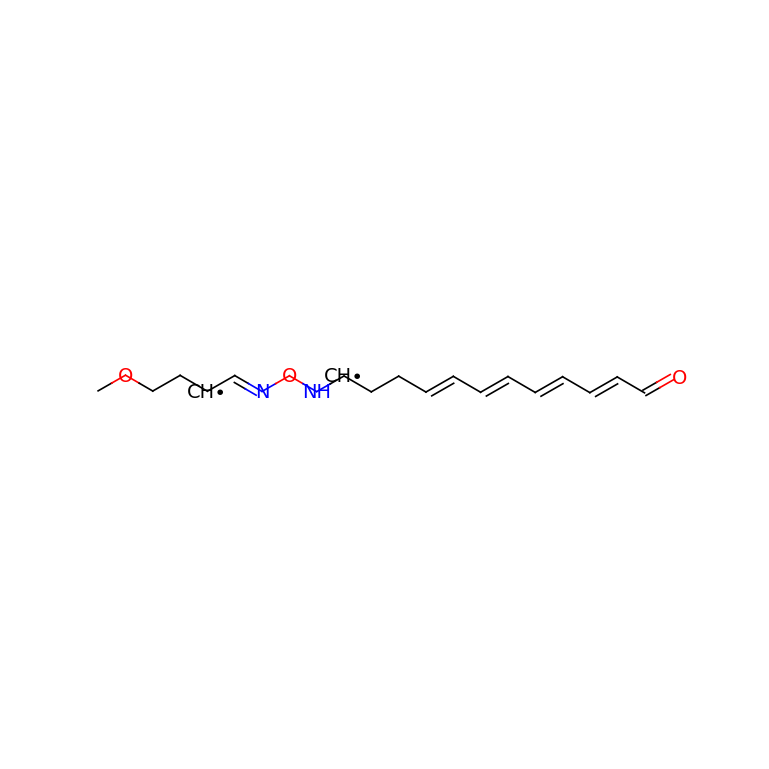

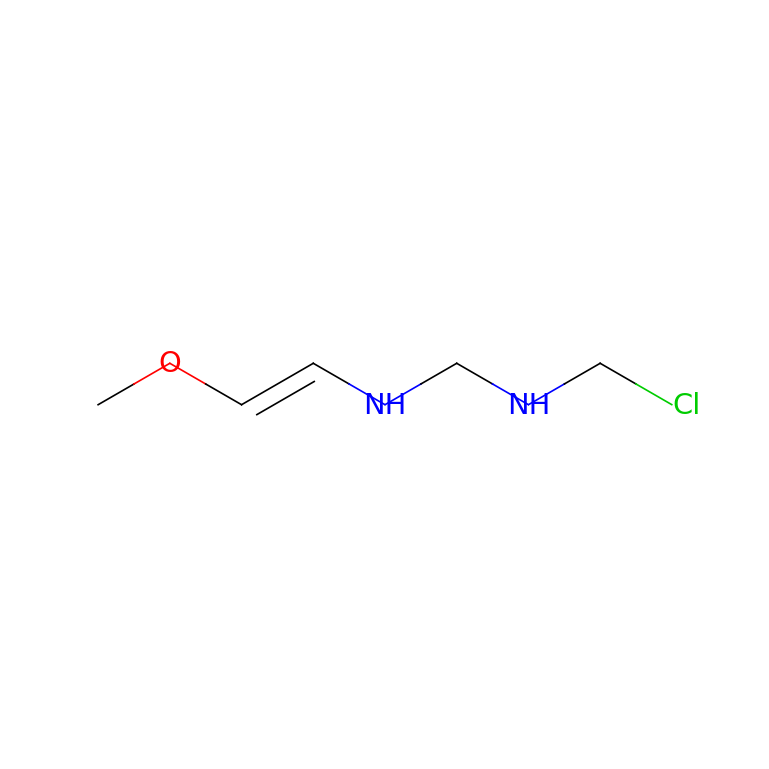

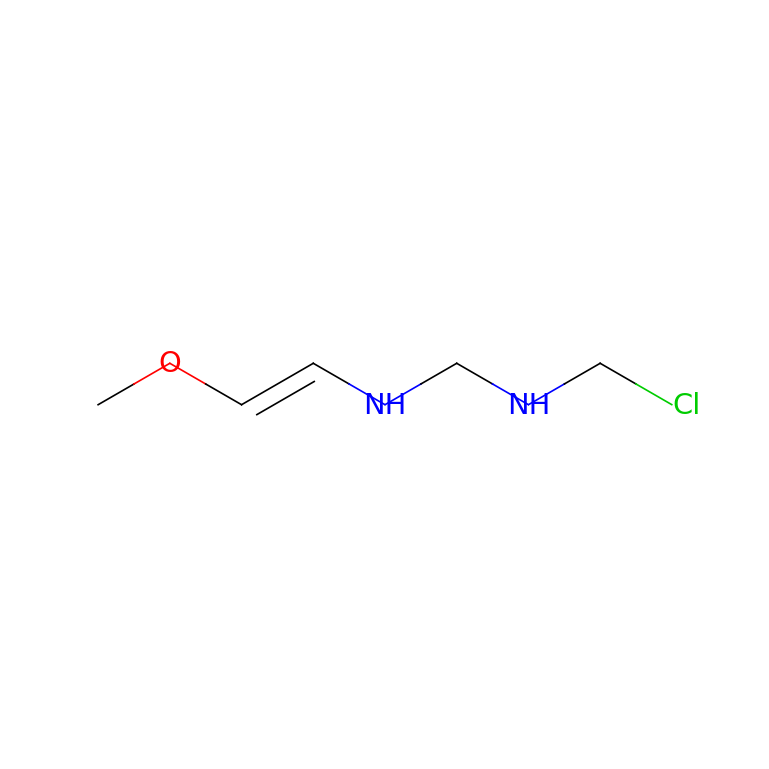

In [6]:
property = 'penalized_logp'
zs, losses = optimize(property, z.detach().clone(), 200)
visualize(property, zs, losses)

generating molecules: 100%|██████████| 200/200 [00:06<00:00, 29.25it/s]


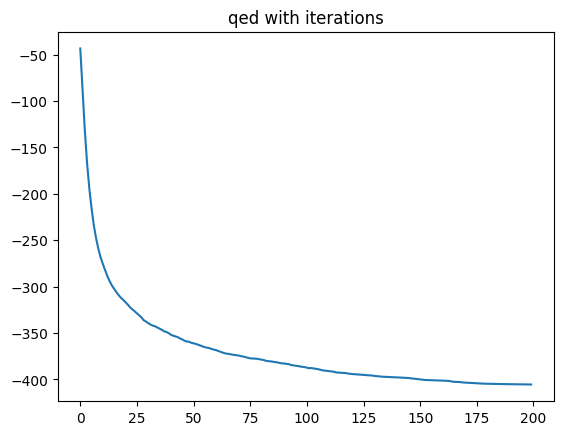

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_39058/2469527915.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


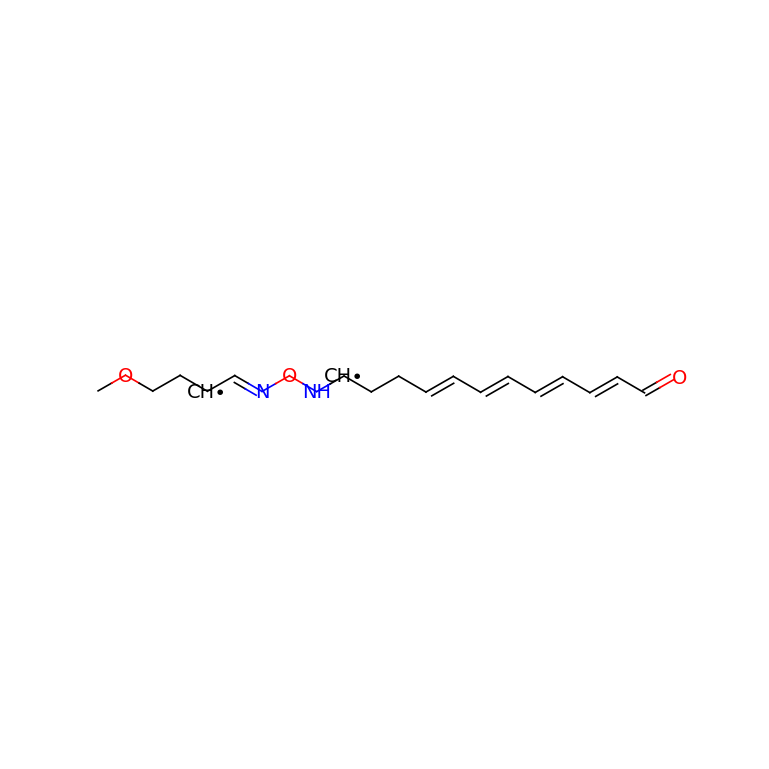

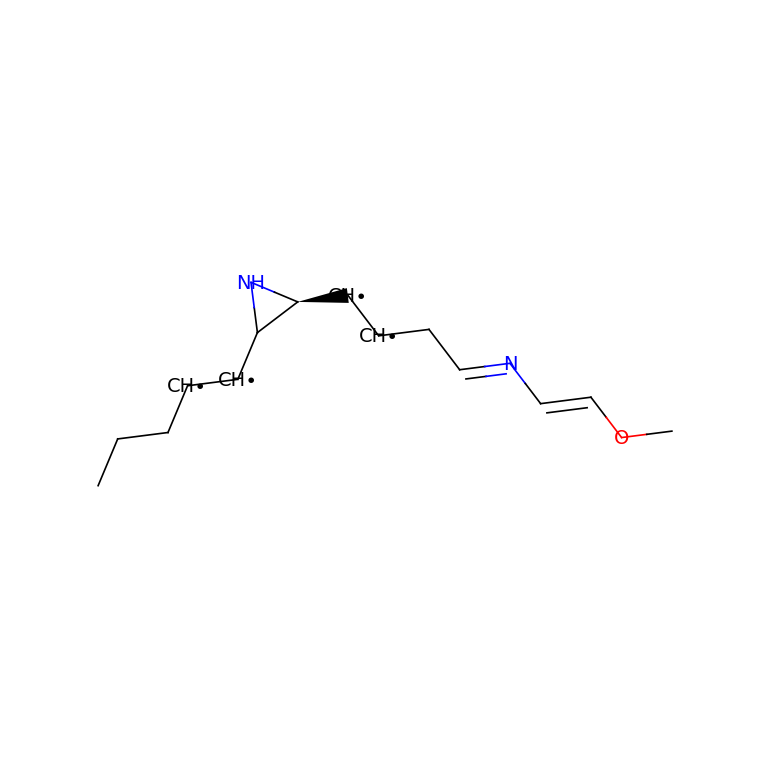

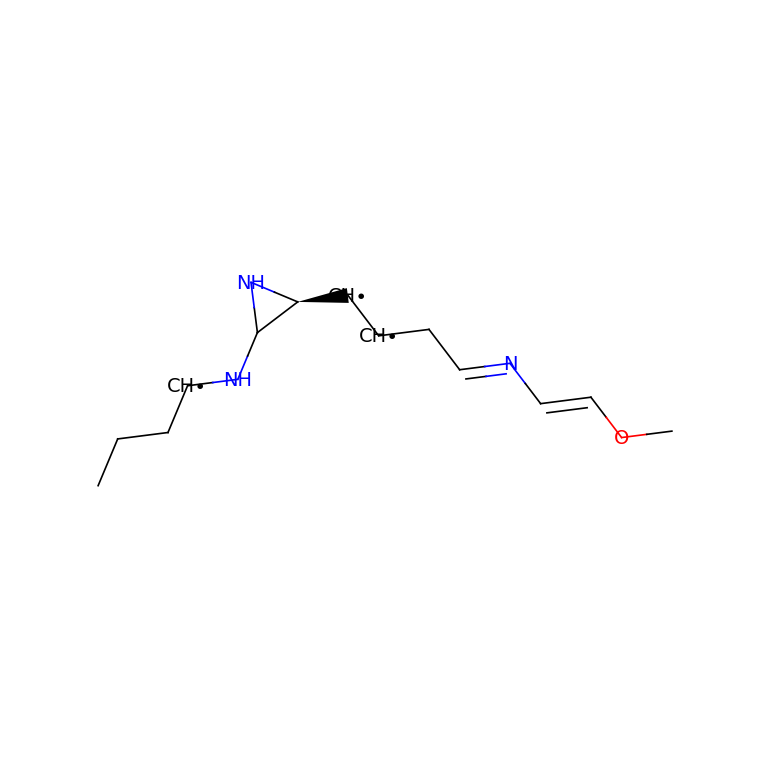

In [7]:
property = 'qed'
zs, losses = optimize(property, z.detach().clone(), 200)
visualize(property, zs, losses)

generating molecules: 100%|██████████| 200/200 [00:06<00:00, 30.40it/s]


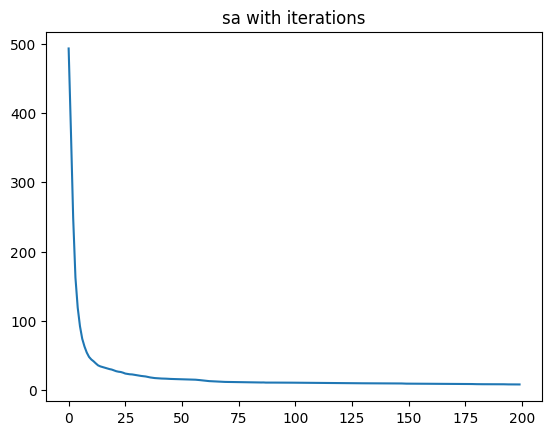

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_39058/2469527915.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


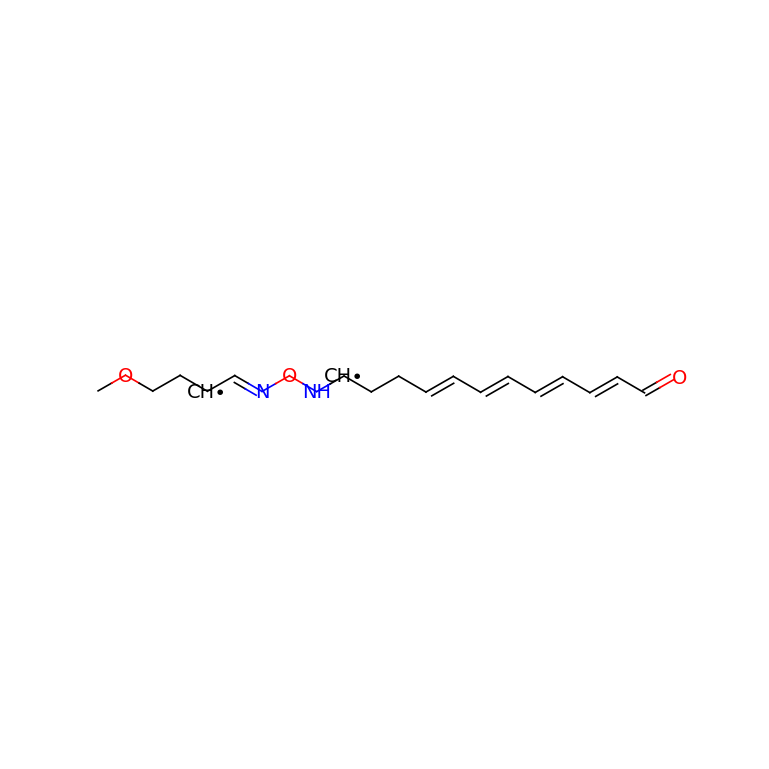

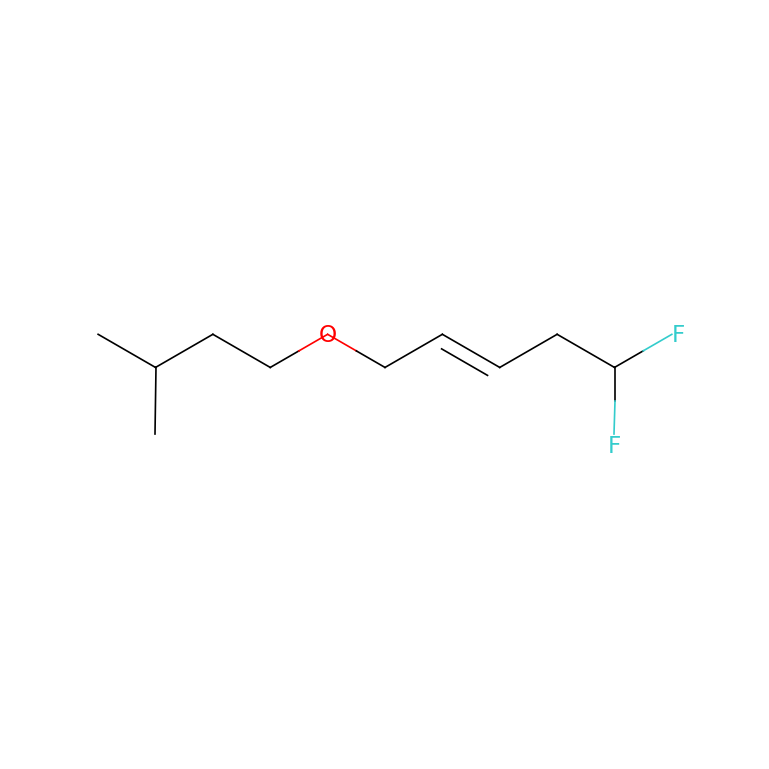

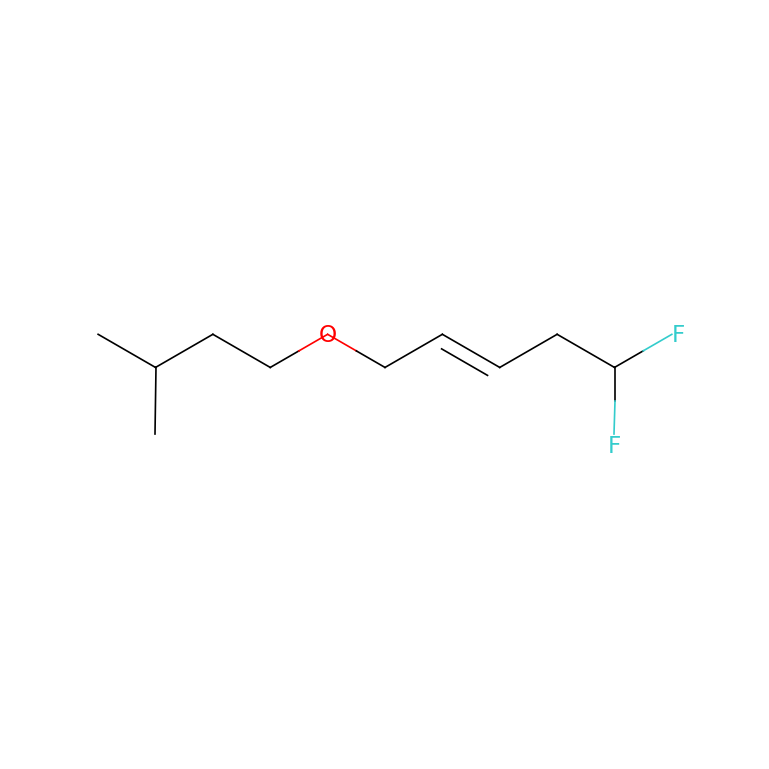

In [8]:
property = 'sa'
zs, losses = optimize(property, z.detach().clone(), 200)
visualize(property, zs, losses)

generating molecules: 100%|██████████| 200/200 [00:07<00:00, 28.42it/s]


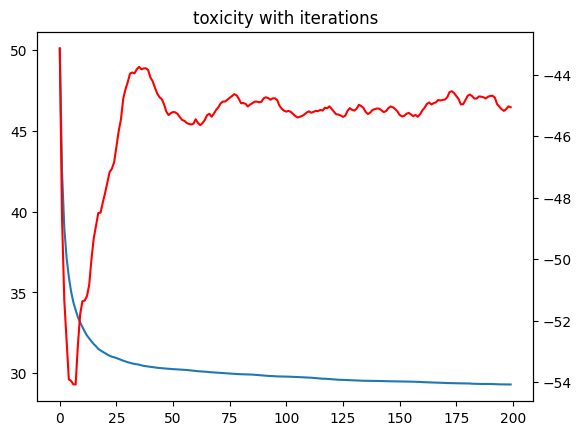

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_39058/2617032979.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


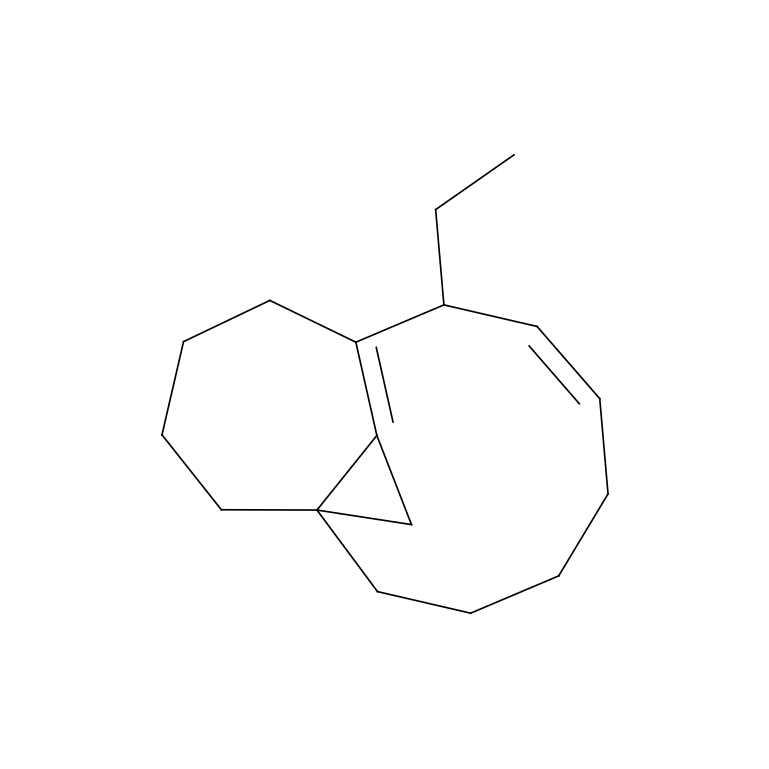

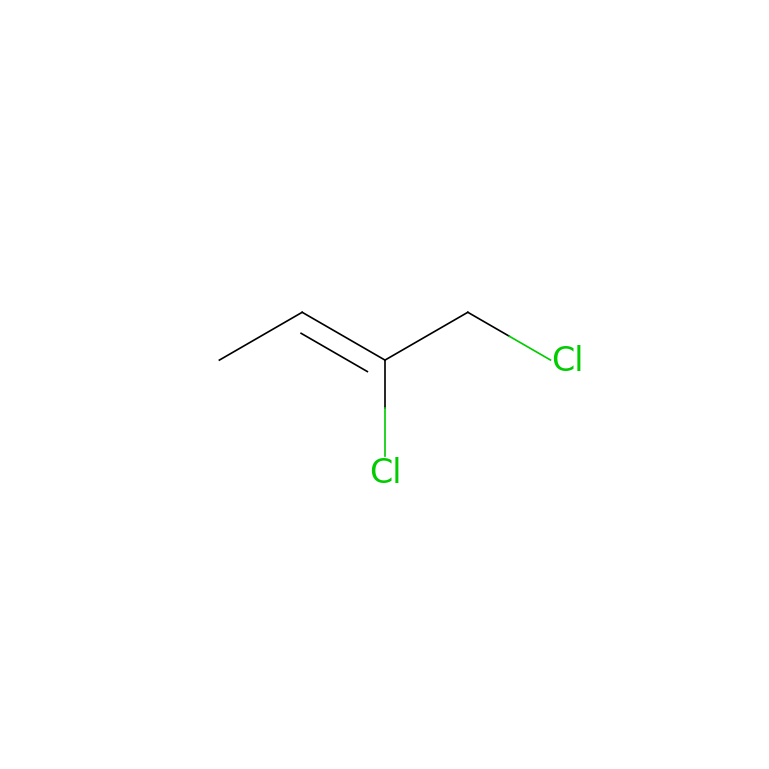

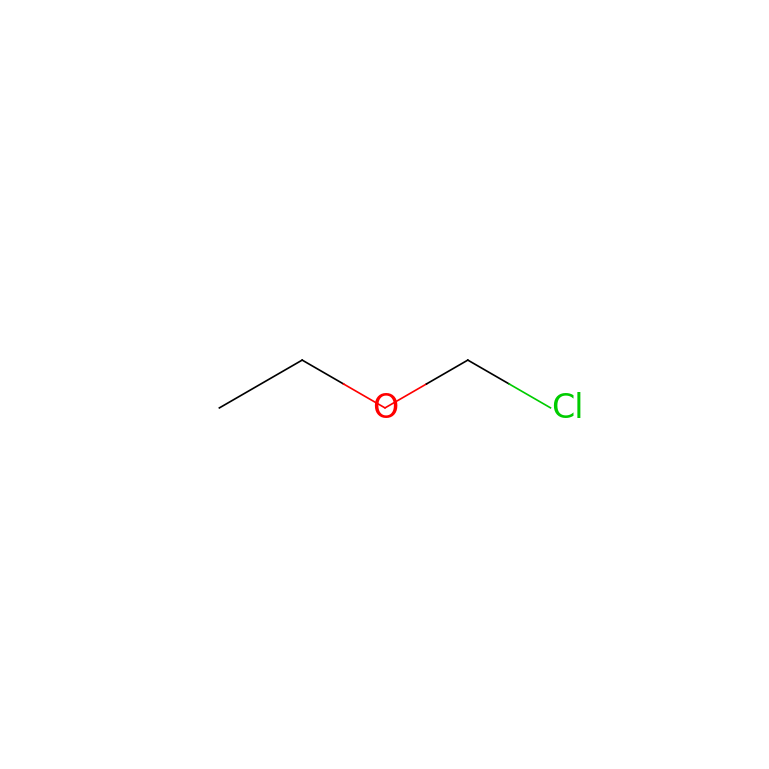

In [20]:
property = 'toxicity'
zs, losses, plotlosses = optimize(property, z.detach().clone(), 200, plot='qed')
visualize(property, zs, losses, plotlosses = plotlosses)

In [30]:
# try various optimization policies
from matplotlib.pyplot import cm

def plot_losses(property, list_losses, list_labels):
    color = iter(cm.rainbow(np.linspace(0, 1, 10)))
    fig = plt.figure()
    ax = plt.axes()
    ax.set_title(property + ' with iterations')
    for i in range(len(list_losses)):
        c = next(color)
        ax.plot(list_losses[i], color=c, label=list_labels[i])
    ax.legend()
    plt.show()

generating molecules: 100%|██████████| 200/200 [00:06<00:00, 31.15it/s]


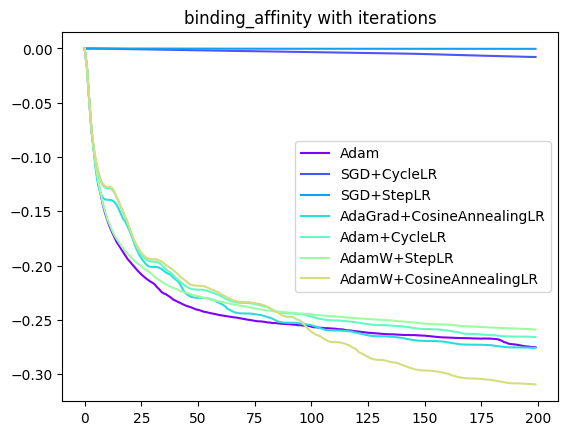

In [ ]:
property = 'binding_affinity'
num_steps = 200
# optimizers = SGD, Adam, Adagrad, AdamW
# schedulers = StepLR, CyclicLR, CosineAnnealingLR
list_losses = []; list_labels = []
_, losses = optimize(property, z.detach().clone(), num_steps)
list_losses.append(losses); list_labels.append('Adam')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'CyclicLR')
list_losses.append(losses); list_labels.append('SGD+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'StepLR')
list_losses.append(losses); list_labels.append('SGD+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adagrad', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('AdaGrad+CosineAnnealingLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adam', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('Adam+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'StepLR')
list_losses.append(losses); list_labels.append('AdamW+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('AdamW+CosineAnnealingLR')
plot_losses(property, list_losses, list_labels)

generating molecules: 100%|██████████| 200/200 [00:05<00:00, 33.40it/s]


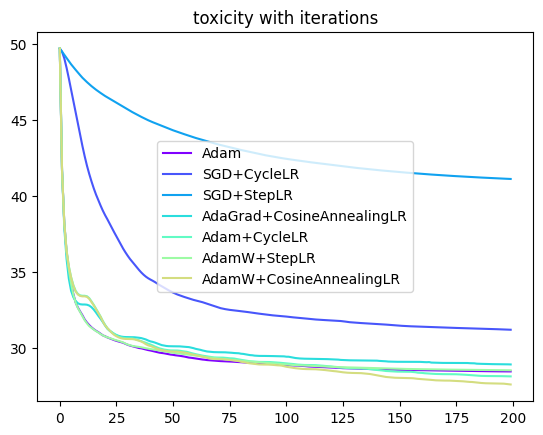

In [31]:
property = 'toxicity'
num_steps = 200
# optimizers = SGD, Adam, Adagrad, AdamW
# schedulers = StepLR, CyclicLR, CosineAnnealingLR
list_losses = []; list_labels = []
_, losses = optimize(property, z.detach().clone(), num_steps)
list_losses.append(losses); list_labels.append('Adam')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'CyclicLR')
list_losses.append(losses); list_labels.append('SGD+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'StepLR')
list_losses.append(losses); list_labels.append('SGD+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adagrad', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('AdaGrad+CosineAnnealingLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adam', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('Adam+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'StepLR')
list_losses.append(losses); list_labels.append('AdamW+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'CosineAnnealingLR')
list_losses.append(losses); list_labels.append('AdamW+CosineAnnealingLR')
plot_losses(property, list_losses, list_labels)

generating molecules: 100%|██████████| 200/200 [00:23<00:00,  8.47it/s]


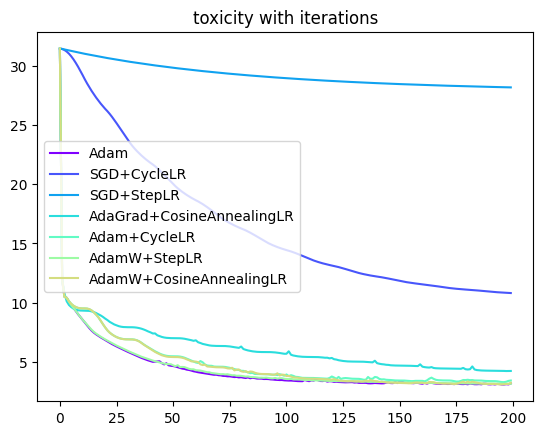

In [32]:
# load transformer model
tran = Transformer(max_len=dm.dataset.max_len, 
          vocab_len=len(dm.dataset.symbol_to_idx), 
          latent_dim=1024, embedding_dim=64).to(device)
tran.load_state_dict(torch.load('tran.pt'))
tran.eval()

# start with 100 random molecules for transformer
num_mols = 100
z = torch.randn((num_mols, tran.max_len, tran.embedding_dim), device=device, requires_grad=True)

# plot properties
property = 'toxicity'
num_steps = 200
list_losses = []; list_labels = []
_, losses = optimize(property, z.detach().clone(), num_steps, model = tran)
list_losses.append(losses); list_labels.append('Adam')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'CyclicLR', model = tran)
list_losses.append(losses); list_labels.append('SGD+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'SGD', sched = 'StepLR', model = tran)
list_losses.append(losses); list_labels.append('SGD+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adagrad', sched = 'CosineAnnealingLR', model = tran)
list_losses.append(losses); list_labels.append('AdaGrad+CosineAnnealingLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'Adam', sched = 'CosineAnnealingLR', model = tran)
list_losses.append(losses); list_labels.append('Adam+CycleLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'StepLR', model = tran)
list_losses.append(losses); list_labels.append('AdamW+StepLR')
_, losses = optimize(property, z.detach().clone(), num_steps, opt = 'AdamW', sched = 'CosineAnnealingLR', model = tran)
list_losses.append(losses); list_labels.append('AdamW+CosineAnnealingLR')
plot_losses(property, list_losses, list_labels)

generating molecules: 100%|██████████| 200/200 [00:24<00:00,  8.30it/s]


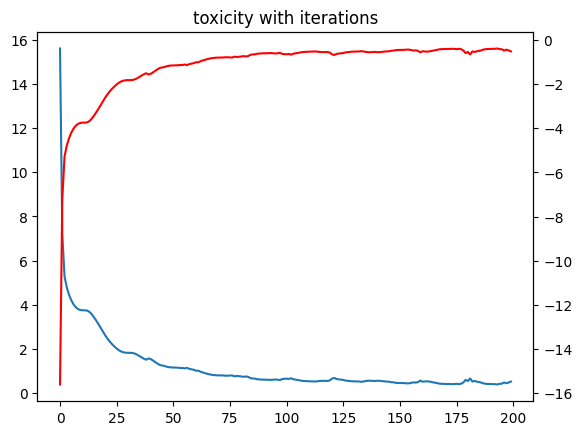

/var/folders/ww/7d6bdg612pv21bk9ykkdncpm0000gp/T/ipykernel_39058/3025318159.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout()


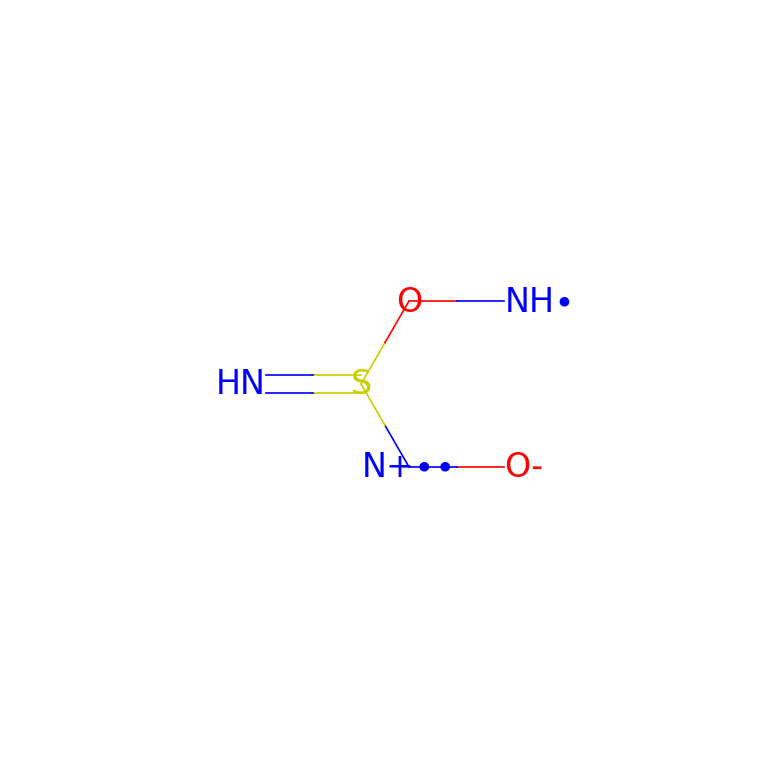

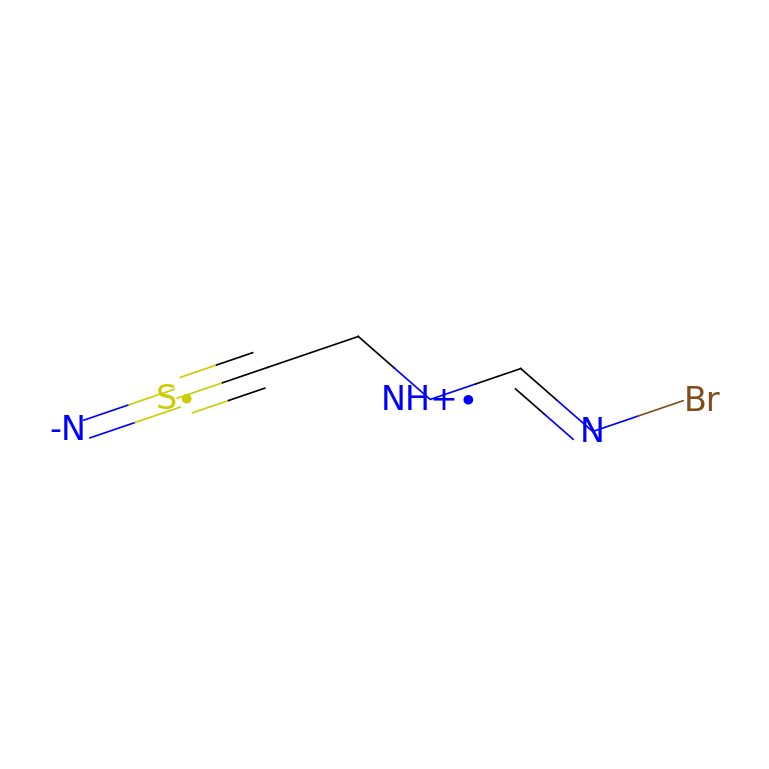

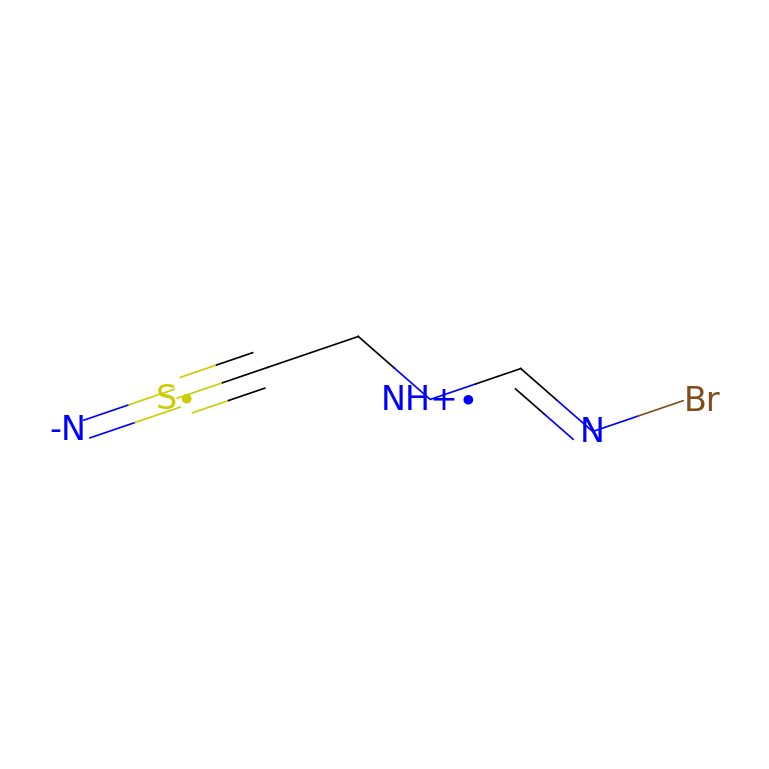

In [42]:
property = 'toxicity'
zs, losses, plotlosses = optimize(property, z.detach().clone(), 200, plot='qed', opt = 'AdamW', sched = 'CosineAnnealingLR', model = tran)
visualize(property, zs, losses, model = tran, plotlosses = plotlosses)

In [ ]:
# TODO: use more memory to train property predictors of transformer for 10k datapoints and not 5k